In [1]:
%load_ext autoreload
%autoreload 2

# Can U-Net predict only the evidence?

What exactly _is_ the evidence in the Skyline12 dataset anyways?

It's actually _scribbles_ that _roughly_ indicate the position of building on the image. There is an individual scribble (points that form a path of a brush stroke) for each building. In our case, to make them usable we create white brush stroke (of a set stroke size) on a black canvas of the same dimensions as each corresponding image. So the evidence is actually an image with black and white pixels.

In [2]:
from datasets.skyline12 import Skyline12

skyline12 = Skyline12('datasets/skyline12/data/')

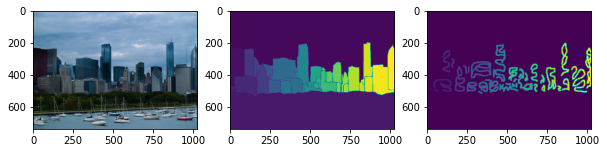

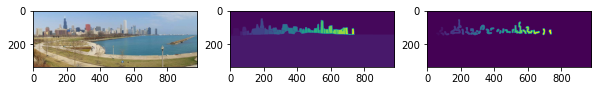

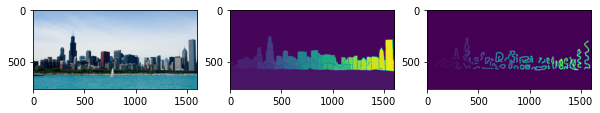

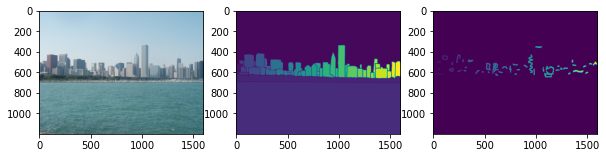

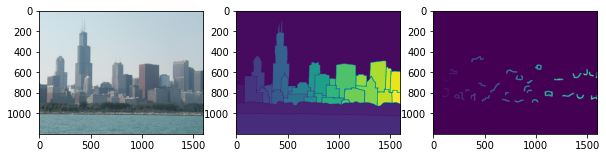

In [3]:
from itertools import islice

for x, y, z in islice(skyline12, 5):
    Skyline12.show_sample(x, [y, z])

As we can see from the small preview of the dataset (ignoring the different colormapping), the scribbles are really sparse. This is expected, as the buildings, at least in the original untampered dataset, take up only a portion of the image. Even so, the density of the drawings vary significantly.

## Training with default settings

In [4]:
import wandb

wandb.init(project='unet-predicting-evidence-only', config={
    'num_classes': 1,
    'loss': 'binary_crossentropy',
    'optimizer': 'adam',
    'learning_rate': 1e-5,
    'learning_rate_decay': None,
    # 'learning_rate_decay_steps': 1000,
    'clipnorm': None,
    'activation': 'sigmoid',
    'batch_size': 3,
    'max_epochs': 100,
    'dataset': 'skyline12',
    'dataset_folds': 20,
})

wandb: Currently logged in as: vassilis_krikonis (use `wandb login --relogin` to force relogin)
/usr/local/lib/python3.6/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [6]:
!mkdir -p /tmp/ds_cache
import tensorflow as tf
import numpy as np
from models.unet import create_unet
from callbacks import LogImagesWandb
from wandb.keras import WandbCallback

tf.random.set_seed(123)
np.random.seed(123)


def keep_xz(x, y, z):
    return x, z


train_ds = (skyline12
            .as_tf_dataset(
                folds=wandb.config['dataset_folds'],
                subset='training',
                cache_dir='/tmp/ds_cache')
            .map(keep_xz))
val_ds = (skyline12
          .as_tf_dataset(
              wandb.config['dataset_folds'],
              subset='validation',
              cache_dir='/tmp/ds_cache')
          .map(keep_xz))

unet = create_unet(
    num_classes=wandb.config['num_classes'],
    output_activation=wandb.config['activation']
)
if wandb.config['loss'] == 'binary_crossentropy':
    loss = tf.keras.losses.BinaryCrossentropy()
else:
    loss = wandb.config['loss']
if wandb.config['optimizer'] == 'adam':
    if wandb.config['learning_rate_decay']:
        lr = tf.keras.optimizers.schedules.ExponentialDecay(
            wandb.config['learning_rate'],
            decay_steps=wandb.config['learning_rate_decay_steps'],
            decay_rate=wandb.config['learning_rate_decay']
        )
    else:
        lr = wandb.config['learning_rate']
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=lr,
        clipnorm=wandb.config['clipnorm']
    )
else:
    optimizer = wandb.config['optimizer']
unet.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy']
)
history = unet.fit(
    train_ds.batch(wandb.config['batch_size']),
    validation_data=val_ds.batch(wandb.config['batch_size']),
    epochs=wandb.config['max_epochs'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5),
        LogImagesWandb(next(iter(val_ds.batch(10)))),
        WandbCallback(save_weights_only=True)
    ]
)

Epoch 1/100
      2/Unknown - 0s 143ms/step - loss: 0.3900 - accuracy: 0.9250WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0899s vs `on_train_batch_end` time: 0.1955s). Check your callbacks.
800/800 [==============================] - 1192s 1s/step - loss: 0.1933 - accuracy: 0.9526 - val_loss: 0.1920 - val_accuracy: 0.9519
Epoch 2/100
800/800 [==============================] - 246s 308ms/step - loss: 0.1782 - accuracy: 0.9526 - val_loss: 0.1805 - val_accuracy: 0.9519
Epoch 3/100
800/800 [==============================] - 247s 309ms/step - loss: 0.1696 - accuracy: 0.9526 - val_loss: 0.1728 - val_accuracy: 0.9519
Epoch 4/100
800/800 [==============================] - 247s 309ms/step - loss: 0.1633 - accuracy: 0.9526 - val_loss: 0.1655 - val_accuracy: 0.9519
Epoch 5/100
800/800 [==============================] - 247s 309ms/step - loss: 0.1583 - accuracy: 0.9526 - val_loss: 0.1596 - val_accuracy: 0.9519
Epoch 6/100
800/800 [======

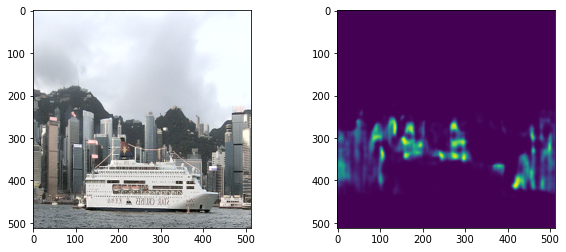

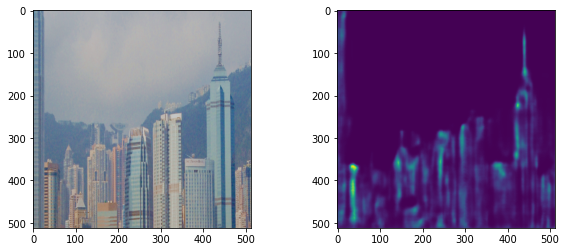

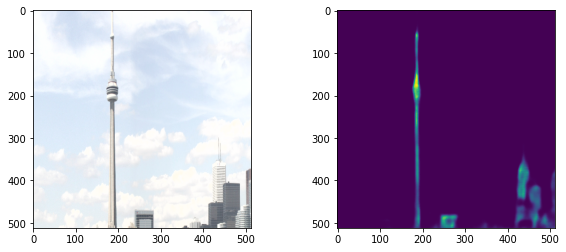

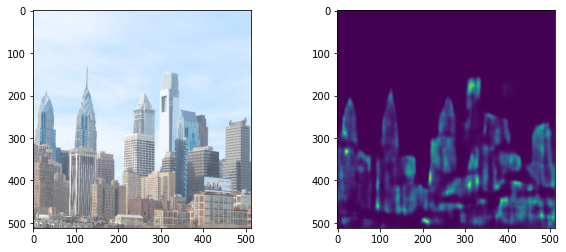

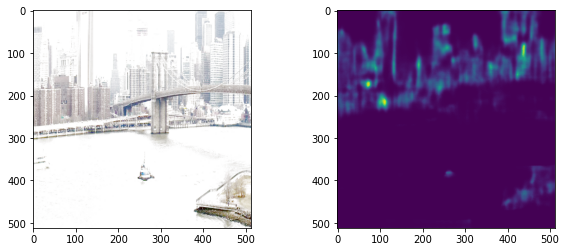

In [7]:
for x, _ in islice(val_ds.batch(1), 5):
    preds = unet(x, training=False)
    Skyline12.show_sample(x[0], [preds[0]], from_tensors=True)

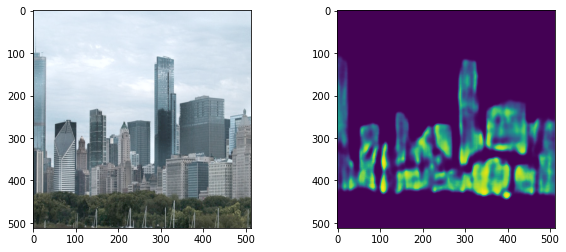

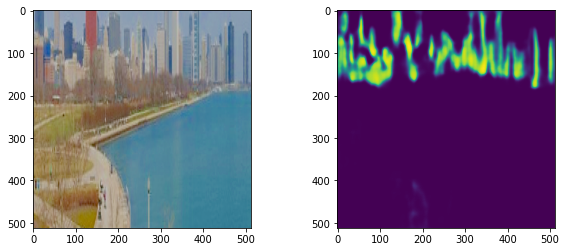

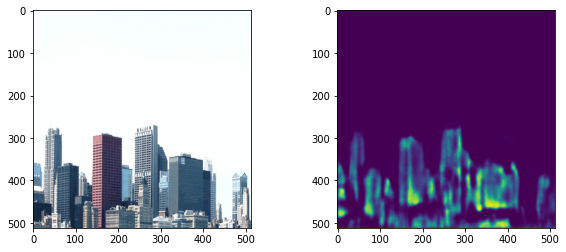

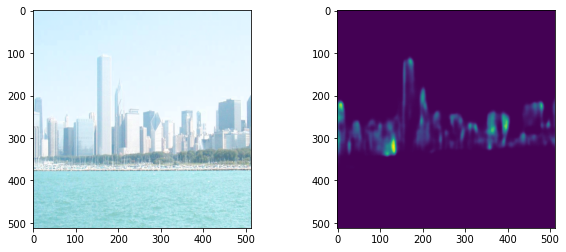

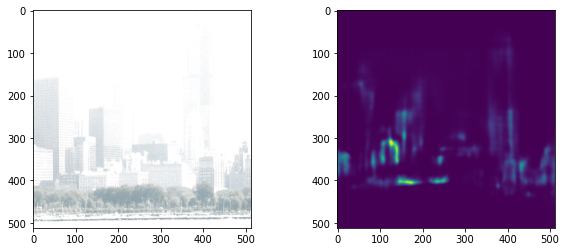

In [8]:
for x, _ in islice(train_ds.batch(1), 5):
    preds = unet(x, training=False)
    Skyline12.show_sample(x[0], [preds[0]], from_tensors=True)

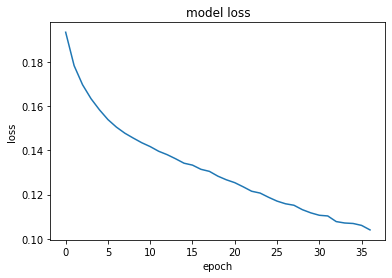

In [9]:
import matplotlib.pyplot as plt


def plot_history(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()


plot_history(history)

In [10]:
wandb.run.finish()

epoch,36
loss,0.10399
accuracy,0.96079
val_loss,0.13494
val_accuracy,0.95551
_step,36
_runtime,10649
_timestamp,1603682625
best_val_loss,0.12876
best_epoch,31


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█
val_loss,█▇▆▅▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▄▅▅▆▆▇▇██▇█▆█▇█▄▅▆
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
